# Quantitative Biology and Biophysics (AS.020.674/618)	Spring 2022
# Gordus Lab 
# February 25, 2022

#  Distributions and Likelihoods

Today we’re going to work with single and double Gaussian data from Viets, et. al (2019). You have been provided with data on blackboard.

One of the libraries you will be using below (tqdm) is very useful for letting you know the progress of a slow loop. I recommend you try it out in the code below.

To pip install:

`pip install tqdm`

To conda install:

`conda install -c conda-forge tqdm`

## Libraries you will need

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.notebook import tqdm

## Plotting Data

We want to explore how these data look. To do this we will first plot this data in a variety of ways using seaborn.

1.	Produce a swarm plot of the data. (Since there are 100 data points, I recommend setting the marker size to 2, i.e. `size = 2`
2.	Produce a violin plot of the data.
3.	Produce a box plot of the data.
4.	Produce a bar plot of the data.

Since the data are in an excel file, the easiest thing to do is import the data using pandas.

## Student Input Cell

In [2]:
# Import data as dataframe
# Data values are the first column of the dataframe, and Data IDs are the second column.


data_df = pd.read_csv('bob_pairing_data_2022.csv')
data_df

,pair distance,Sample
0,1.300000,control
1,0.447214,control
2,1.100000,control
3,1.800000,control
4,1.811077,control
...,...,...
595,0.700000,E
596,0.800000,E
597,2.039608,E
598,1.627882,E


## Student Input Cell

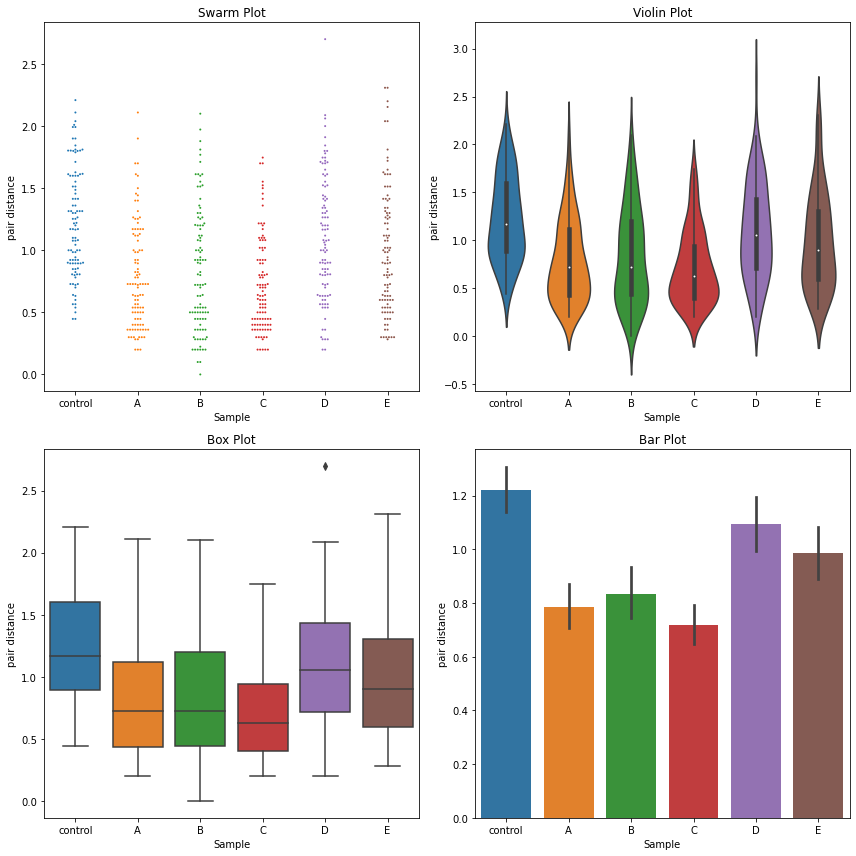

In [3]:
# Plot the 4 seaborn plots

x='Sample'
y='pair distance'

fig, ax = plt.subplots(2,2, figsize=(12,12))

sns.swarmplot(x=x, y=y, data=data_df, ax=ax[0,0], size=2)
ax[0, 0].set_title('Swarm Plot')

sns.violinplot(x=x, y=y, data=data_df, ax=ax[0,1])
ax[0, 1].set_title('Violin Plot')

sns.boxplot(x=x, y=y, data=data_df, ax=ax[1,0])
ax[1, 0].set_title('Box Plot')

sns.barplot(x=x, y=y, data=data_df, ax=ax[1,1])
ax[1, 1].set_title('Bar Plot')

plt.tight_layout()
plt.show()

## How to do math with arrays

I normally like to work in the realm of arrays, rather than DataFrames. This is because I like to leverage the power and speed of executing linear algebra functions instead of FOR loops. These functions are pre-compiled, so they are much faster. Iteratively going through arrays or DataFrames is computationally exhaustive, and take a long time to run when using large arrays of data.

So, first I make a numpy array where the **rows are observations, and columns are samples.**

In [4]:
#convert dataframe to numpy array
data_n = data_df.to_numpy()
data_n = pd.to_numeric(data_n[:,0])
data_n.resize(6,100)
data_n = np.transpose(data_n)

Next, I can compute the mean and standard deviation for every sample with one command, by setting the axis = 0.

In [5]:
mu = np.nanmean(data_n, axis = 0)
sigma = np.nanstd(data_n, axis = 0)

Isn't that great? Instead of creating a `for` loop and calculating the mean for each column, I simply told the function which axis to use to calculate the mean for the entire array. Both mu and sigma have 6 entries, because I calculated the mean for each column (down the rows, or `axis = 0`). If I had chosen `axis=1`, mu and sigma would be 100 elements long, because I would have calculated the mean and standard deviation of each row.

## Gaussian Log Likelihood Function

In the last exercise, I showed you how you can simply use the scipy.stats library for calculating common distributions. However, I would like you to get you more accustomed with performing math in python, so **I want you to calculate your own Gaussian probability distribution.**

<img src="http://www.gordus.org/public_images/gauss.png" style="width: 300px;"/>

There will be three inputs for your function: `x, mu, sigma`, which will be your `data_n` (x), mean (mu), and standard deviation (sigma).

To calculate the Gaussian function, we can again take advantage of using matrices, and negate the need to iteratively perform calculations with a `for` loop. A key detail here is when subtracting the mean (mu) from the columns of data_n. The rows of data_n are observations, and the columns are samples. I want to subtract each element of mu from its corresponding column of data_n, i.e. subtract `mu[0]` from `data_n[:,0]`, and `mu[1]` from `data[:,1]`, etc. 

Intuitively, you want to do this in a `for` loop. However, normally you could take advantage of linear algebra, and convert mu into a matrix with something called an identity matrix, and then subtract that from data_n, thus bypassing the need for a `for` loop.

HOWEVER, Python is accostomed to this, so it does the math for you. If you give it an arithmetic problem between a matrix and a vector, it will look at the length of the vector, and see if the matrix has a dimension with matching length. If it does, it will perform the arithmetic along this dimension. SO, in the example below, when I perform x - mu, Python does all the linear algegra for me. SO CONVENIENT.

In [6]:
# Example

example_data = np.array([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])
mu_test = np.mean(example_data, axis = 0)

mean_centered_data = example_data - mu_test

print(mean_centered_data)

[[-5. -5. -5. -5. -5.]
 [ 0.  0.  0.  0.  0.]
 [ 5.  5.  5.  5.  5.]]


## Student Input Cell

In [7]:
def gauss_fun(x,mu,sigma):
    
    c = 1 / np.sqrt(2*np.pi*(sigma**2))
    l = -(x-mu)**2 / (2*(sigma**2))
    P = c*np.exp(l)
    
    return P

# To confirm your function above is correct, compare it to the solution you get with scipy's function

test = norm.pdf(data_n,mu,sigma)

p_gauss = gauss_fun(data_n,mu,sigma)

print(np.round(np.sum(np.abs(test-p_gauss))))

0.0


Now that you have a function that calculates a Gaussian distribution, create another function that calculates the log-likelihood for that function:

<img src="http://www.gordus.org/public_images/gaussian_log2.png" style="width: 300px;"/>


## Student Input Cell

In [8]:
# Gaussian logL
    
def gausslogl(x, mu, sigma):
    
    ln_gauss = np.log(gauss_fun(x, mu, sigma))
    
    logL = np.sum(ln_gauss, axis=0)
    
    return logL

Now you can use your two functions to calculate the log-likelihood function for a Gaussian fit to your data.

## Student Input Cell

In [9]:
lp1 = gausslogl(data_n, mu, sigma)
lp1

array([-58.21034174, -55.56109143, -71.39712661, -45.17889682,
       -71.88530104, -72.97747604])

## Double Gaussian Log Likelihood Function

Next up is calculating the log likelihood function for the double Gaussian. The double gaussian likelihood function is simply the log of the sum of two Gaussians. HOWEVER, first we need to find the optimal values of w, mu1, mu2, sigma1, and sigma2. Unlike the single gaussian, where we can simply calculate the mean and standard deviation, the double Gaussian does not have analytical solutions for these values.

<img src="http://www.gordus.org/public_images/double_gauss.png" style="width: 500px;"/>


This is a common problem in physics. To get around this, you can have your computer find the best approximation for the highest likelihood function. Like we did in class, you want your computer to keep guessing the best parameter values, and choose the values that produce the largest log-likelihood estimate.

Most libraries don't have maximize functions, but they DO have MINIMIZE functions (I will explain the reason for this in a future class). However, you can still use a MINIMIZE function to calculate a maximum: you simply optimize your parameters to find the MINIMUM NEGATIVE log-likelihood function.

THEREFORE, the function below returns the NEGATIVE of the log-likelihood so that the minimum of this is actually the maximum for the log likelihood function.

To have your Double Gaussian log likelihood function in the right format, I am going to start the function for you. **Remember, you can take advantage of the fact you have already written a function to calculate a single Gaussian.**

**NOTE: I have put a negative sign on the return value to make sure this function returns the NEGATIVE log-likelihood funciton, since that is what we are going to MINIMIZE.**

## Student Input Cell

In [10]:
# Double Gaussian log likelihood function

def dgausslogl(params,x):
    
    mu1 = params[0]
    mu2 = params[1]
    sigma1 = params[2]
    sigma2 = params[3]
    w = params[4]
    
    p1 = gauss_fun(x, mu1, sigma1)
    p2 = gauss_fun(x, mu2, sigma2)
    
    ln_P = np.log(w*p1 + (1-w)*p2)
    
    logL = np.sum(ln_P, axis=0)
    
    return -logL


Next, we will determine the most likely parameters for a double Gaussian for each sample, using the minimize operator. We will then use these parameters to calculate the log likelihood value for each sample. I have to initialize the minimize optimizer with some values, so I use slightly adjusted means and sigmas from the single Gaussians as reasonable guesses.

**Notice that when I record the log likelihood for the double Gaussian, I am recording the negative value, since I know the function outputs the negative of the log likelihood function. By recording the negative of a negative, I am recording the positive log liklihood value.**

tqdm: Optimizers can take a while to run, so to monitor this, I took advantage of the tqdm toolbar which you imported above.

**Since we have not covered optimizers yet, I will calculate the most likely double Gaussian parameters for you, using your function from above.**

## Double Gaussian parameter optimization

In [11]:
logL1 = gausslogl(data_n, mu, sigma)
logL2 = np.zeros(np.shape(logL1))

params_double = np.zeros((5,6))

for m in tqdm(range(len(mu))):
    params0 = [mu[m] - sigma[m], mu[m] + sigma[m], sigma[m], sigma[m], 0.6]
    result = minimize(dgausslogl, params0, args=data_n[:,m], method='Nelder-Mead')
    params_double[:,m] = result.x
    logL2[m] = -dgausslogl(result.x,data_n[:,m])

logL2

array([-52.54778936, -44.19938435, -61.28927015, -32.43702073,
       -69.0730055 , -63.89582389])

## BIC Calculation

Now that we've calculated the log likelihood functions for both the single and double Gaussian distributions, we're ready to calculate the BIC! Calculate the BIC for the data fit to a single Gaussian, and double Gaussian. Report which model is more likely for each sample.

<img src="http://www.gordus.org/public_images/bic.png" style="width: 300px;"/>


**Remember, the model that produces the LOWEST BIC is the one that is most likely, RELATIVE to the other models it is compared to.**

In [12]:
# BIC: Best model has LOWEST BIC
    

single = 2*np.log(100) - 2*lp1
double = 5*np.log(100) - 2*logL2

diff = double - single

samples = ['Control', '   A   ', '   B   ', '   C   ', '   D   ', '   E   ']

for i in range(6):
    if diff[i] < 0:
        dist = 'DOUBLE GAUSSIAN'
    else:
        dist = 'SINGLE GAUSSIAN'

    print('{} is more likely to come from a {} distribution. ({} vs. {})\
          '.format(samples[i], dist, np.round(single[i], 2), np.round(double[i], 2)))

Control is more likely to come from a SINGLE GAUSSIAN distribution. (125.63 vs. 128.12)          
   A    is more likely to come from a DOUBLE GAUSSIAN distribution. (120.33 vs. 111.42)          
   B    is more likely to come from a DOUBLE GAUSSIAN distribution. (152.0 vs. 145.6)          
   C    is more likely to come from a DOUBLE GAUSSIAN distribution. (99.57 vs. 87.9)          
   D    is more likely to come from a SINGLE GAUSSIAN distribution. (152.98 vs. 161.17)          
   E    is more likely to come from a DOUBLE GAUSSIAN distribution. (155.17 vs. 150.82)          
